<a href="https://colab.research.google.com/github/ImagingDataCommons/idc-radiomics-reproducibility/blob/main/notebooks/pai_processing_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook showcases a processing example of the pipeline published in [Pai et Al. - *Foundation Models for Quantitative Biomarker Discovery in Cancer Imaging*](https://www.medrxiv.org/content/10.1101/2023.09.04.23294952v1), reproduced with the tools provided by the Imaging Data Commons and the Google Cloud Platform.

The goal of this notebook is to provide the user with an example of how such tools can be used to run an AI/ML end-to-end analysis on cohorts hosted by the Imaging Data Commons portal, and to describe what we identified as the best practices to do so.


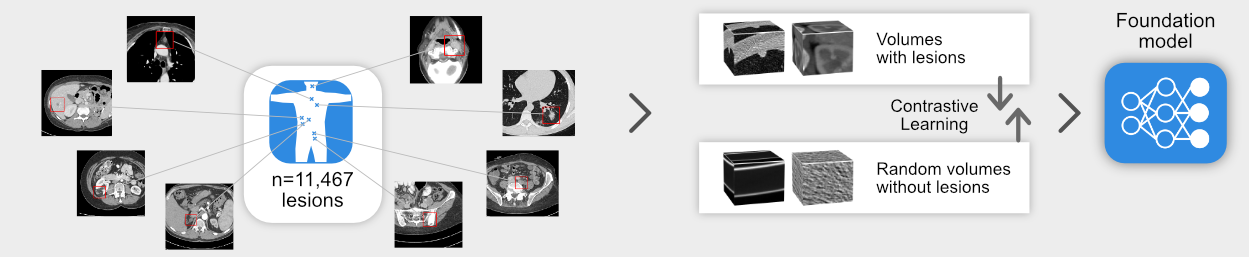

The notebook is part of the [IDC Radiomics Reproducibility](https://github.com/ImagingDataCommons/idc-radiomics-reproducibility) repository. If you use the code found in this notebook or you want to refer to some of our findings, please cite:

> Dennis Bontempi, Leonard Nuernberg, Deepa Krishnaswamy, Ahmed Hosny, Keyvan Farahani, Ron Kikinis, Andriy Fedorov, Hugo Aerts - _Transparent and Reproducible AI-based Medical Imaging Pipelines Using the Cloud_

As well as the original paper:

> Suraj Pai, Dennis Bontempi, Vasco Prudente, Ibrahim Hadzic, Mateo Sokač, Tafadzwa L. Chaunzwa, Simon Bernatz, Ahmed Hosny, Raymond H Mak, Nicolai J Birkbak, Hugo JWL Aerts - _Foundation Models for Quantitative Biomarker Discovery in Cancer Imaging_


---

The Imaging Data Commons GCS buckets are free to access and download from - but in order to run the BigQuery query and proceed, we need to authenticate with a Google Account. Running this notebook will be completely free.

Additional documentation regarding the Imaging Data Commons and its integration with the Google Cloud Platform can be found at the following page: https://learn.canceridc.dev/portal/getting-started

In [ ]:
from google.colab import auth
auth.authenticate_user()

Another essential to run the analyses is to have a Google Cloud Project setup in the account we authenticated with. Setting up a GCP project is free and take seconds. To learn how to create a project (for free) and get started with IDC, you can visit the following resources:

* [Create a Google Cloud Project](https://developers.google.com/workspace/guides/create-project)
* [Getting started with IDC](https://learn.canceridc.dev/getting-started-with-idc)



Before proceeding with the notebook, **remember to set** `my_ProjectID` **to the ID of your project!**

In [ ]:
# initialize this variable with your Google Cloud Project ID!
my_ProjectID = "idc-sandbox-000"

---

# Environment Setup

In this section, we are going to take care of the environment setup: making sure all of the dependencies are installed and working, creating the directory tree we need to run the pipeline, and so on.

Depending on how many Colab credits you have, you can either run this notebook using a CPU or a GPU. The processing times are relatively fast, so attaching a GPU to this Colab instance is not mandatory.

If you want to access the free GPUs Colab provides, you can do so at:
`Edit > Notebooks Settings`.

From the dropdown menu under `Hardware accelerator`, select `GPU`. Let's check the Colab instance is indeed equipped with a GPU.

In [ ]:
# check wether the use of a GPU was correctly enabled
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "not found" in gpu_list[0] else True

---

Next, we will need to install the few dependencies the notebook relies on. Note how most of the python packages we will use (e.g., `numpy`, `matplotlib`, ...) are nowadays part of the base Colab installation, and therefore won't need setup.


We can start by installing the `foundation-cancer-image-biomarker` package prepared by the authors. This will take care of the installation of several other python dependencies, and provide useful functions we will use troughout the notebook - so running the next cell could take a few minutes.

In [ ]:
%%capture
%pip install foundation-cancer-image-biomarker --pre -U

We can start by importing all the neccessary modules from the `foundation-cancer-image-biomarker` package. These modules provide utilities for downloading the LUNG1 dataset, loading models, running inference and visualization of steps in the pipeline.

All of the public data used in this study was downloaded from the Imaging Data Commons (IDC). In the other notebooks at the [IDC Radiomics Reproducibility](https://github.com/ImagingDataCommons/idc-radiomics-reproducibility) repository, we downloaded datasets hosted on IDC using BigQuery and the `%%bigquery` IPython Magic as seen in the example provided as part of the [IDC tutorial series](https://github.com/ImagingDataCommons/IDC-Tutorials). As part of this tutorial, since the authors of the paper shared the cohort manifest files and utility functions to download the cohort from IDC, we are going to use such files and functions (`download_LUNG1` and `download_RADIO`).

In [ ]:
from fmcib.utils import download_LUNG1, download_RADIO, build_image_seed_dict
from fmcib.models import resnet50, get_linear_classifier
from fmcib.preprocessing import preprocess
from fmcib.visualization import visualize_seed_point
import pandas as pd

---

# Getting Data from the Imaging Data Commons

## Download Samples from the LUNG1 Dataset

We can start by downloading the NSCLC-Radiomics (also known as LUNG1) dataset from the Imaging Data Commons.

Additional details regarding this dataset are available [here](https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics).

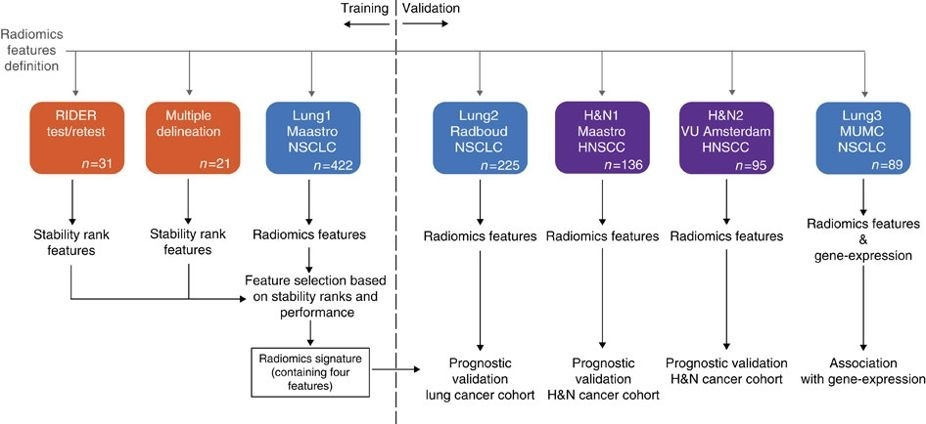


To do so, we fetch a preconfigured manifest file from Imaging Data Commons (https://datacommons.cancer.gov/repository/imaging-data-commons) and then pull the DICOM data from google cloud storage into the folder specified using the `download_LUNG1` utility function.

To learn how the authors generated the manifest file, you can follow [this notebook](https://colab.research.google.com/drive/1AsRLdNCW_m20DRzQBFCBFSieGJthV8nu?usp=sharing). This can be used for other cohorts on IDC as well, allowing you to test additional datasets with the foundation models in this notebook.


The DICOM data is sorted into the following structure:
````
<Download Folder>
├── PatientID
    ├── StudyInstanceUID
        └──  List of dicom files with the format <Modality>_<SeriesInstanceUID>_<InstanceNumber>

````



In [ ]:
download_LUNG1("lung1", samples=5) # Download only 5 patients for testing

100%|██████████| 563/563 [00:14<00:00, 37.58it/s]


## Download Samples from the NSCLC-Radiogenomics Dataset

Next, we can download the second dataset the authors used in the study: NSCLC-Radiogenomics.

Additional details regarding this dataset can be found [here](https://wiki.cancerimagingarchive.net/display/Public/NSCLC+Radiogenomics).

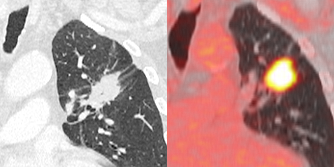


Once again, we fetch a preconfigured manifest file from Imaging Data Commons (https://datacommons.cancer.gov/repository/imaging-data-commons) and then pull the DICOM data from google cloud storage into the folder specified using the `download_RADIO` utility function.

The DICOM data is sorted into the following structure:
````
<Download Folder>
├── PatientID
    ├── StudyInstanceUID
        └──  List of dicom files with the format <Modality>_<SeriesInstanceUID>_<InstanceNumber>

````



In [ ]:
download_RADIO("radio", samples=5) # Download only 5 patients for testing

100%|██████████| 5122/5122 [01:41<00:00, 50.30it/s]


# Data Pre-processing

The first step for the replication of the foundation model pipeline is converting the DICOM files (CT and RTSTRUCT for LUNG1; CT and DICOM-SEG for RADIO) into NIfTI files using [`dcmrtstruct2nii`](https://github.com/Sikerdebaard/dcmrtstruct2nii) and [`pydicom-seg`](https://razorx89.github.io/pydicom-seg/).

The seed points (i.e., Center of Mass of the tumours), necessary to run the foundation model pipeline, can be extracted from the NIFTI masks for the primary tumor.

In [ ]:
lung1_df = build_image_seed_dict("lung1", samples=5) # Get the first 5 samples
radio_df = build_image_seed_dict("radio", samples=5) # Get the first 5 samples

100%|██████████| 5/5 [00:41<00:00,  8.27s/it]


We can inspect one of the generated sample by visualizing the axial, sagittal and coronal view along with the seed point annotation. First, from the LUNG1 dataset:

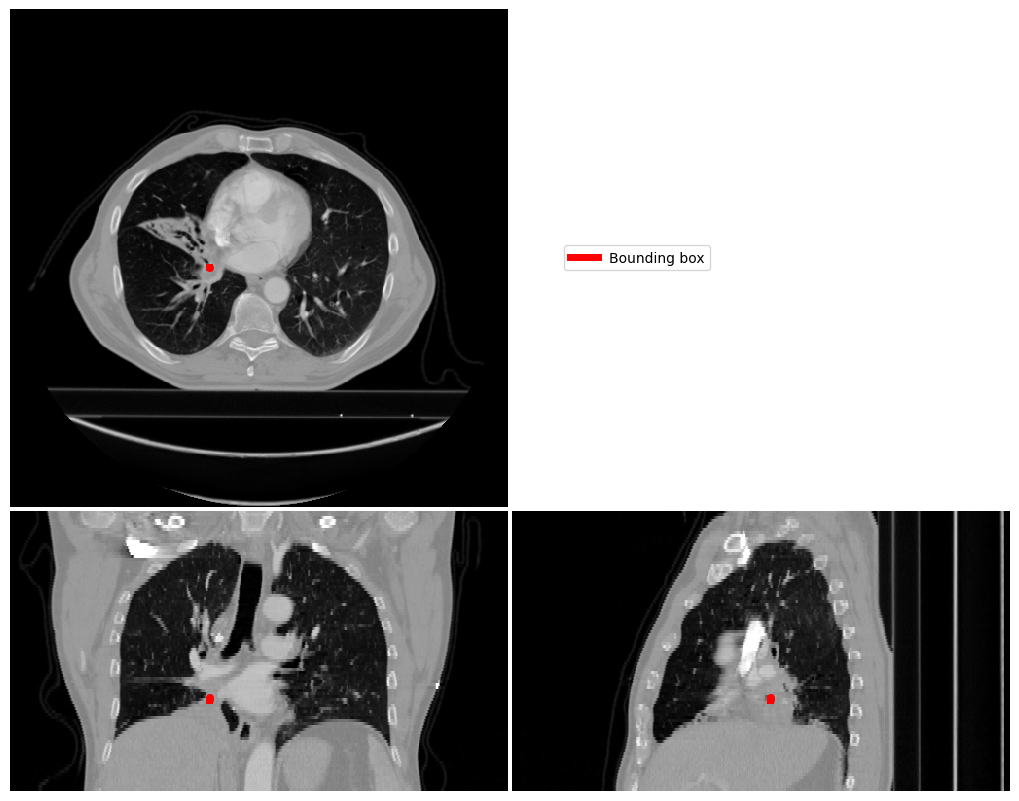

In [ ]:
lung1_row = dict(lung1_df.iloc[0])
visualize_seed_point(lung1_row)

Second, from the NSCLC-Radiogenomics dataset:

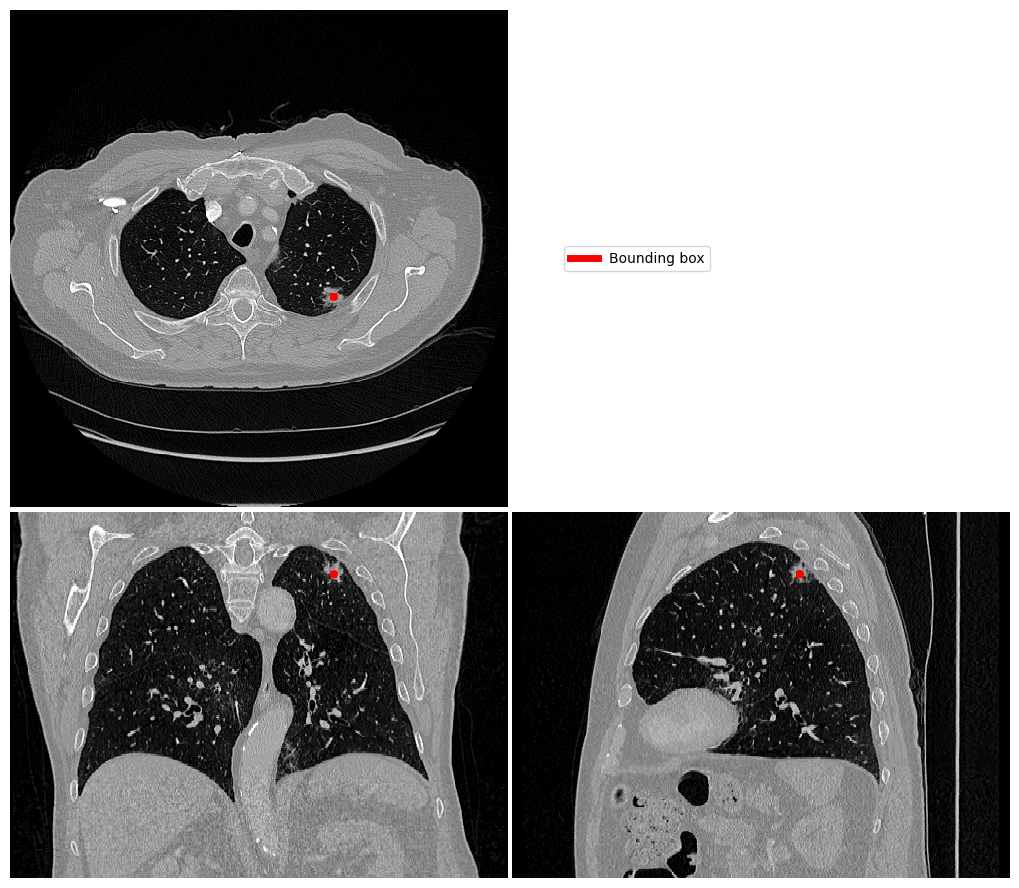

In [ ]:
radio_row = dict(radio_df.iloc[0])
visualize_seed_point(radio_row)

The foundation model will extract deep features from a cube cropped around such seed points. These features will then be used to compute the risk score for every patient.

---

# Data Processing/AI Inference

We can now download and load the pre-trained ResNet50 foundation model shared by the authors, by using the `resnet50` utility function from `fmcib.models`.

In [ ]:
model = resnet50(device="cpu")

Downloading: 100% [738451713 / 738451713] bytes

We should now preprocess the data using several transform chains from the authors' `preprocessing` functions, to then provide the processed input (a small CT cube containing a lesion) to the pre-trained model to extract features. We can inspect the shape of the features and visualize them as a histogram. Once again, we can do so for LUNG1:

Feature shape: (1, 4096)


array([[<Axes: title={'center': '0'}>]], dtype=object)

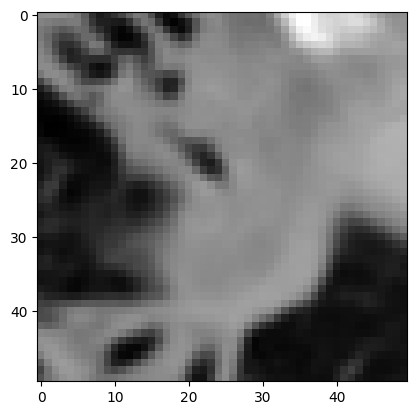

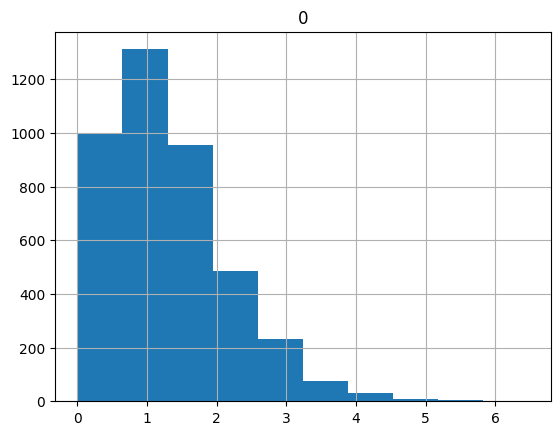

In [ ]:
processed_input = preprocess(lung1_row)

import matplotlib.pyplot as plt
plt.imshow(processed_input[0, 25], cmap="gray") # View the 25th axial slice

lung1_features = model(processed_input.unsqueeze(0)).detach().numpy()
print("Feature shape:", lung1_features.shape)
pd.DataFrame(lung1_features.flatten()).hist()

And for the NSCLC-Radiogenomics dataset:

Feature shape: (1, 4096)


array([[<Axes: title={'center': '0'}>]], dtype=object)

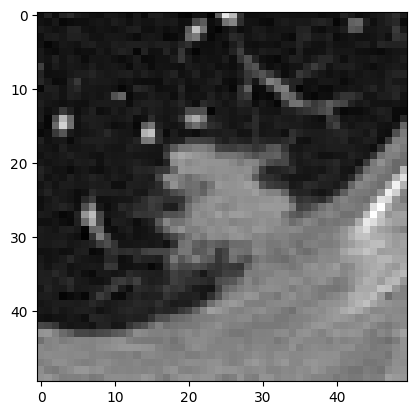

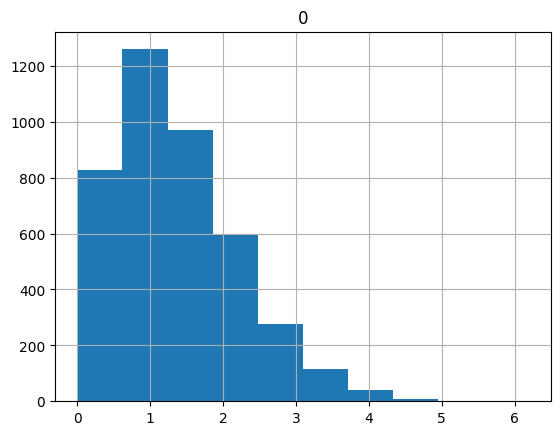

In [ ]:
processed_input = preprocess(radio_row)

import matplotlib.pyplot as plt
plt.imshow(processed_input[0, 25], cmap="gray") # View the 25th axial slice

radio_features = model(processed_input.unsqueeze(0)).detach().numpy()
print("Feature shape:", radio_features.shape)
pd.DataFrame(radio_features.flatten()).hist()